Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Wrangle ML datasets

- [ ] Continue to clean and explore your data. 
- [ ] For the evaluation metric you chose, what score would you get just by guessing?
- [ ] Can you make a fast, first model that beats guessing?

**We recommend that you use your portfolio project dataset for all assignments this sprint.**

**But if you aren't ready yet, or you want more practice, then use the New York City property sales dataset for today's assignment.** Follow the instructions below, to just keep a subset for the Tribeca neighborhood, and remove outliers or dirty data. [Here's a video walkthrough](https://youtu.be/pPWFw8UtBVg?t=584) you can refer to if you get stuck or want hints!

- Data Source: [NYC OpenData: NYC Citywide Rolling Calendar Sales](https://data.cityofnewyork.us/dataset/NYC-Citywide-Rolling-Calendar-Sales/usep-8jbt)
- Glossary: [NYC Department of Finance: Rolling Sales Data](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page)

In [ ]:
!pip install pdpbox
!pip install shap

In [ ]:
# Imports

import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from scipy.stats import pearsonr
from shap import TreeExplainer, initjs, force_plot
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor, XGBClassifier

In [ ]:
# Needed to use Colab for Shap to install
# Upload files to Colab

from google.colab import files
files.upload()

TypeError: ignored

In [ ]:
# Wrangle Data

pd.set_option('display.max_rows', 150)

def readIn(file, parse_d='DATE', idx='DATE'):
    """ Opens .csv file, creates datetime index, and returns DataFrame"""

    DATA_PATH = '../data/build_finance/'
    df = pd.read_csv(file,
                     parse_dates=[parse_d]).set_index(idx)
    return df


def manyToOne(files_m, files_q, file_w):
    """Accepts lists of .csv files and returns single DataFrame"""

    # Takes monthly and quarterly files, has them read_in, parses their
    # dates, and return DataFrames held in lists
    frames_m = [readIn(file) for file in files_m]
    frames_q = [readIn(file) for file in files_q]

    # Reads in SP500 data, indicates columns to use, and capitalizes 'DATE'
    # for consistency with other DataFrames held in frames_m and frames_q
    DATA_PATH = '../data/build_finance/'
    sp = pd.read_csv(file_w, usecols=['Date', 'Close'],
                     parse_dates=['Date']).set_index('Date')
    sp.rename(columns={'Date': 'DATE', 'Close': 'SP500_CLOSE'}, inplace=True)

    # Concatenate DataFrames held in frames_m and frames_q
    concat_m = pd.concat(frames_m, axis=1)
    concat_q = pd.concat(frames_q, axis=1)

    # Final concatenation of all DataFrames (monthly data, quarterly data 
    # and SP500 data)
    last = pd.concat([concat_m, concat_q, sp], axis=1)

    # SP500 data is only available from 1/1/1985
    # Mask out dates prior to January 1st, 1985
    mask = last.index >= '1985-01-01'
    df_final = last.loc[mask]
    df_final.shape

    # Return DataFrame
    return df_final


def wrangle(files_m, files_q, file_w):
    # Pass .csv files and have a single DataFrame returned
    df = manyToOne(files_m, files_q, file_w)

    # Rename columns
    df.columns = ['cpi', '10yr_treasury', 'housing_starts', 
                  'industrial_prod', 'initial_claims', 'unemployment_rate', 
                  'corp_profits', 'exports_goods_svs', 'gdp', 'net_exports',
                  'sp500_close']

    # Reorganize columns
    cols_reorder = ['10yr_treasury', 'corp_profits', 'cpi', 'exports_goods_svs', 
                    'gdp','housing_starts', 'industrial_prod', 
                    'initial_claims', 'net_exports', 'unemployment_rate',
                    'sp500_close']

    df = df.reindex(columns=cols_reorder)

    # Create a target feature, month-ahead-return: positive/negative - 
    # Binary Classification
    df['sp_ahead'] = df['sp500_close'].shift(-1)
    df['sp_ahead_pos_neg'] = (df['sp500_close'].shift(-1) - df['sp500_close']) > 0

    # Drop leaky features
    df.drop(columns=['sp500_close', 'sp_ahead'], inplace=True)

    # Forward fill the quarterly data
    df.ffill(inplace=True)

    # Create new feature the shows the montly change in monthly initial unemployment 
    # claims
    # df['init_claims_ma_unemployment_rate'] = 1 - (df['initial_claims'] / df['unemployment_rate'].shift(-1))
    # df['unemployment_rate_ma_houseing_starts'] = 1 - (df['unemployment_rate'] / df['housing_starts'].shift(-1))
    # #df['change_housing_starts'] = 1 - (df['housing_starts'] / df['housing_starts'].shift(+1))

    # Drop 'initial_claims'
    df.drop(columns='initial_claims', inplace=True)
    # df.drop(columns=['unemployment_rate', 'initial_claims', 'housing_starts'], inplace=True)

    # Remove outliers
    # df.drop(columns=['10yr_treasury', 'corp_profits', 'cpi', 'gdp', 
    #                  'housing_starts', 'industrial_prod', 'net_exports'], inplace=True)
    # # df = df.loc[ (df['unemployment_rate'] <= 10.0) &
    #              (df['initial_claims'] <= 1_000_000)]

    # df.drop(columns=['cpi', 'gdp', 'initial_claims'], inplace=True)

    # Return wrangled DataFrame
    return df


file_w = '^GSPC_m.csv'

files_m = ['CPI.csv',
           'DGS10.csv',
           'HOUST.csv',
           'INDPRO.csv',
           'INITCLMS.csv',
           'UNRATE.csv']

files_q = ['CP.csv',
           'EXPGS.csv',
           'GDP.csv',
           'NETEXP.csv',]


#df = manyToOne(files_m, files_q, file_w)

df = wrangle(files_m, files_q, file_w)
print(df.shape)
df.tail(10)

(427, 10)


,10yr_treasury,corp_profits,cpi,exports_goods_svs,gdp,housing_starts,industrial_prod,net_exports,unemployment_rate,sp_ahead_pos_neg
2019-10-01,1.706818,2000.736,257.387,2515.671,19253.959,1340.0,109.0270,-549.757,3.6,True
2019-11-01,1.812105,2000.736,257.989,2515.671,19253.959,1371.0,110.0388,-549.757,3.6,True
2019-12-01,1.862857,2000.736,258.203,2515.671,19253.959,1587.0,109.6527,-549.757,3.6,False
2020-01-01,1.757619,1739.103,258.687,2438.710,19010.848,1617.0,109.1845,-494.307,3.5,False
2020-02-01,1.504211,1739.103,258.824,2438.710,19010.848,1567.0,109.2966,-494.307,3.5,False
2020-03-01,0.870000,1739.103,257.989,2438.710,19010.848,1269.0,104.5221,-494.307,4.4,True
2020-04-01,0.657619,1557.064,256.192,1788.166,17302.511,934.0,91.2658,-545.164,14.8,True
2020-05-01,0.674000,1557.064,255.942,1788.166,17302.511,1038.0,92.0613,-545.164,13.3,True
2020-06-01,0.728636,1557.064,257.282,1788.166,17302.511,1265.0,97.8019,-545.164,11.1,True
2020-07-01,0.623636,2118.856,258.604,2071.577,18596.521,1487.0,101.9086,-736.124,10.2,False


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 427 entries, 1985-01-01 to 2020-07-01
Freq: MS
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   exports_goods_svs  427 non-null    float64
 1   unemployment_rate  427 non-null    float64
 2   sp_ahead_pos_neg   427 non-null    bool   
dtypes: bool(1), float64(2)
memory usage: 10.4 KB


In [ ]:
df.describe()

,10yr_treasury,corp_profits,cpi,exports_goods_svs,gdp,housing_starts,industrial_prod,net_exports,unemployment_rate
count,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000
mean,5.055184,957.571611,183.506023,1314.937642,13402.600963,1344.859485,87.019208,-365.595581,5.941920
std,2.414908,627.991309,45.321474,717.308475,3351.732788,392.796055,16.966103,241.881939,1.645123
min,0.623636,171.499000,105.700000,297.273000,7824.247000,478.000000,56.023400,-805.630000,3.500000
25%,2.869524,375.422000,146.150000,671.600000,10091.049000,1101.500000,68.319000,-548.149000,4.700000
50%,4.733810,721.414000,181.200000,1090.490000,13559.032000,1376.000000,93.223700,-405.497000,5.600000
75%,6.855000,1599.159000,226.351500,2105.084000,15825.096000,1622.000000,101.714450,-107.694000,6.900000
max,11.855238,2118.856000,258.824000,2550.287000,19253.959000,2273.000000,110.551600,-20.536000,14.800000




 Correlation coefficients and p values for unemployment_rate and sp500_close:


,correlation_coefficients,p_values
gdp,0.921455,1.278788e-176
cpi,0.904093,5.101689e-159
exports_goods_svs,0.894028,2.712999e-150
industrial_prod,0.865456,1.189859e-129
corp_profits,0.860630,1.233172e-126
initial_claims,0.079179,1.022762e-01
housing_starts,-0.203200,2.328281e-05
unemployment_rate,-0.264437,2.900099e-08
net_exports,-0.712323,2.443694e-67
10yr_treasury,-0.822998,1.922726e-106




 Heatmap correlation betwen features and sp500_close:


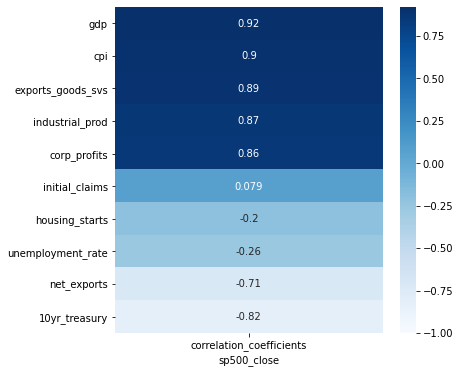



 Correlation coefficients and p values for unemployment_rate and sp_ahead:


,correlation_coefficients,p_values
gdp,0.919745,1.032061e-174
cpi,0.903142,3.742913e-158
exports_goods_svs,0.892684,3.403643e-149
industrial_prod,0.862061,1.616850e-127
corp_profits,0.861654,2.887023e-127
initial_claims,0.095374,4.889350e-02
housing_starts,-0.205111,1.941791e-05
unemployment_rate,-0.256145,7.994356e-08
net_exports,-0.707526,4.553945e-66
10yr_treasury,-0.824242,4.957091e-107




 Heatmap correlation betwen features and sp_ahead:


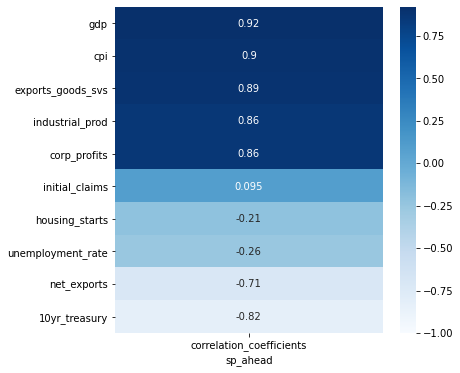

In [ ]:
# Let's examine the correlations between the SP500 closing prices and the features
# Initial claims, housing starts, and unemployment rates appear weakly, or very 
# weakly correlated.

# Examining the correllations between the month ahead SP500 closing prices and the 
# features presents largely in the same manner. 

# Will explore model performance without these features
# Will also try creating new features with these variables to see if they change 
# correlations at all. 

feature_cols = list(df.columns[:-3])
target_cols = list(df.columns[-3:-1])

for entry in target_cols:
    corr_coefs = []
    p_vals = []
    for column in feature_cols:
        corrcoef = pearsonr(df[column], df[entry])[0]
        pval = pearsonr(df[column], df[entry])[1]
        corr_coefs.append(corrcoef)
        p_vals.append(pval)

    print(f'\n\n Correlation coefficients and p values for {column} and {entry}:')       
    corrs_sp500_close = pd.DataFrame({'correlation_coefficients': corr_coefs, 
                                    'p_values': p_vals}, index=feature_cols)
    corrs_sp500_close.sort_values(by='correlation_coefficients', ascending=False, inplace=True)
    display(corrs_sp500_close)


    print(f'\n\n Heatmap correlation betwen features and {entry}:')       
    plt.figure(figsize=(6,6))
    sns.heatmap(corrs_sp500_close[['correlation_coefficients']],
            vmin=-1,
            cmap='Blues',
            annot=True);
    plt.xlabel(entry)  
    plt.show();



 Correlation coefficients and p values for corp_profits and remaining features:


,correlation_coefficients,p_values
exports_goods_svs,0.975039,6.722974e-280
cpi,0.960145,2.083645e-237
gdp,0.951300,2.531396e-219
industrial_prod,0.865097,2.013637e-129
unemployment_rate,0.031120,5.213028e-01
initial_claims,0.024624,6.118621e-01
housing_starts,-0.437317,2.256678e-21
net_exports,-0.819896,5.391396e-105
10yr_treasury,-0.889329,1.624797e-146




 Heatmap correlation betwen features and corp_profits:


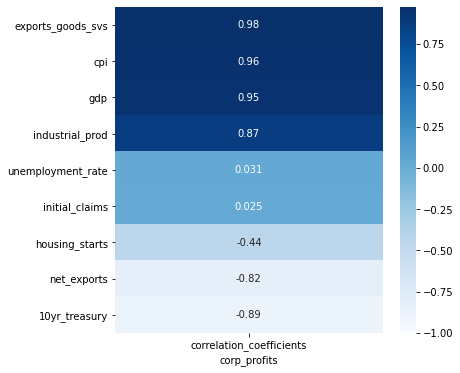



 Correlation coefficients and p values for exports_goods_svs and remaining features:


,correlation_coefficients,p_values
cpi,0.977807,1.276045e-290
corp_profits,0.975039,6.722974e-280
gdp,0.965283,6.614264e-250
industrial_prod,0.888053,1.609711e-145
initial_claims,0.002062,9.661162e-01
unemployment_rate,-0.028802,5.528227e-01
housing_starts,-0.494099,1.148496e-27
net_exports,-0.780060,1.417882e-88
10yr_treasury,-0.907591,2.797363e-162




 Heatmap correlation betwen features and exports_goods_svs:


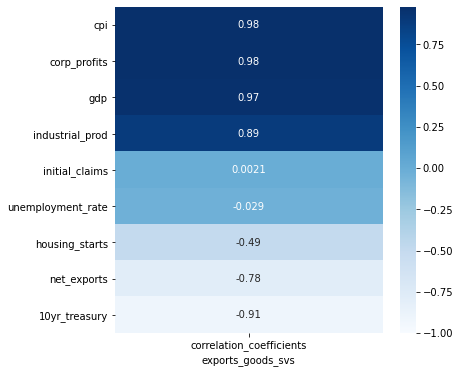



 Correlation coefficients and p values for net_exports and remaining features:


,correlation_coefficients,p_values
10yr_treasury,0.771881,1.261427e-85
housing_starts,0.113403,1.907508e-02
unemployment_rate,0.087264,7.164283e-02
initial_claims,-0.021835,6.527590e-01
exports_goods_svs,-0.780060,1.417882e-88
corp_profits,-0.819896,5.391396e-105
cpi,-0.825722,9.751255e-108
gdp,-0.864446,5.197802e-129
industrial_prod,-0.883844,2.567850e-142




 Heatmap correlation betwen features and net_exports:


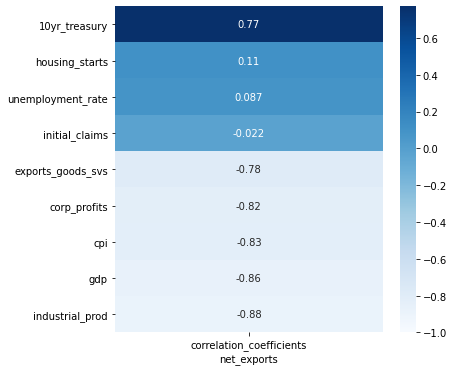



 Correlation coefficients and p values for gdp and remaining features:


,correlation_coefficients,p_values
cpi,0.991340,0.000000e+00
exports_goods_svs,0.965283,6.614264e-250
industrial_prod,0.957736,4.197469e-232
corp_profits,0.951300,2.531396e-219
initial_claims,0.042565,3.802812e-01
unemployment_rate,-0.105077,2.993517e-02
housing_starts,-0.339064,6.009633e-13
net_exports,-0.864446,5.197802e-129
10yr_treasury,-0.935007,1.863311e-193




 Heatmap correlation betwen features and gdp:


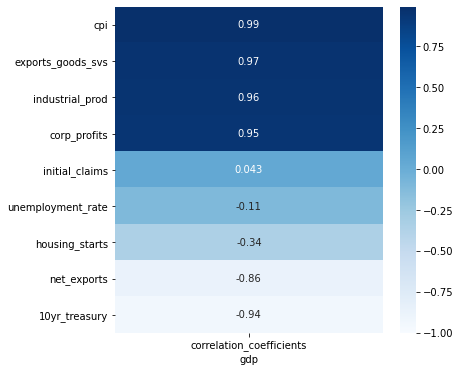



 Correlation coefficients and p values for 10yr_treasury and remaining features:


,correlation_coefficients,p_values
net_exports,0.771881,1.261427e-85
housing_starts,0.399477,8.630850e-18
unemployment_rate,-0.068746,1.561690e-01
initial_claims,-0.124321,1.012827e-02
industrial_prod,-0.887897,2.128729e-145
corp_profits,-0.889329,1.624797e-146
exports_goods_svs,-0.907591,2.797363e-162
gdp,-0.935007,1.863311e-193
cpi,-0.948881,5.792701e-215




 Heatmap correlation betwen features and 10yr_treasury:


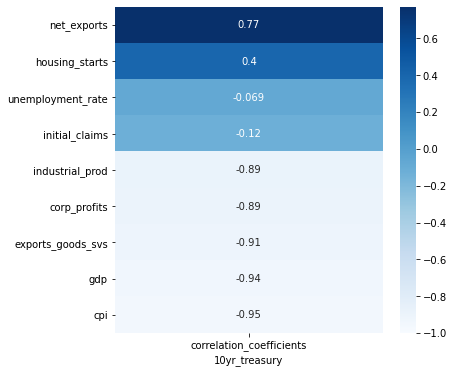



 Correlation coefficients and p values for cpi and remaining features:


,correlation_coefficients,p_values
gdp,0.991340,0.000000e+00
exports_goods_svs,0.977807,1.276045e-290
corp_profits,0.960145,2.083645e-237
industrial_prod,0.932133,1.344893e-189
initial_claims,0.084949,7.953341e-02
unemployment_rate,-0.013828,7.757033e-01
housing_starts,-0.432088,7.514332e-21
net_exports,-0.825722,9.751255e-108
10yr_treasury,-0.948881,5.792701e-215




 Heatmap correlation betwen features and cpi:


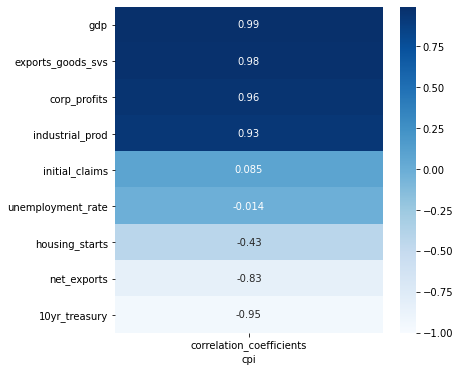



 Correlation coefficients and p values for industrial_prod and remaining features:


,correlation_coefficients,p_values
gdp,0.957736,4.197469e-232
cpi,0.932133,1.344893e-189
exports_goods_svs,0.888053,1.609711e-145
corp_profits,0.865097,2.013637e-129
initial_claims,-0.033669,4.877542e-01
housing_starts,-0.193091,5.914863e-05
unemployment_rate,-0.234975,9.098657e-07
net_exports,-0.883844,2.567850e-142
10yr_treasury,-0.887897,2.128729e-145




 Heatmap correlation betwen features and industrial_prod:


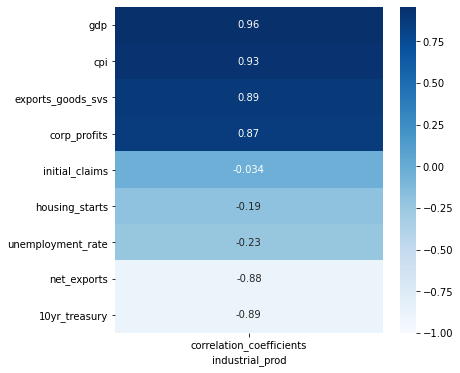



 Correlation coefficients and p values for unemployment_rate and remaining features:


,correlation_coefficients,p_values
initial_claims,0.484518,1.607620e-26
net_exports,0.087264,7.164283e-02
corp_profits,0.031120,5.213028e-01
cpi,-0.013828,7.757033e-01
exports_goods_svs,-0.028802,5.528227e-01
10yr_treasury,-0.068746,1.561690e-01
gdp,-0.105077,2.993517e-02
industrial_prod,-0.234975,9.098657e-07
housing_starts,-0.535792,4.246492e-33




 Heatmap correlation betwen features and unemployment_rate:


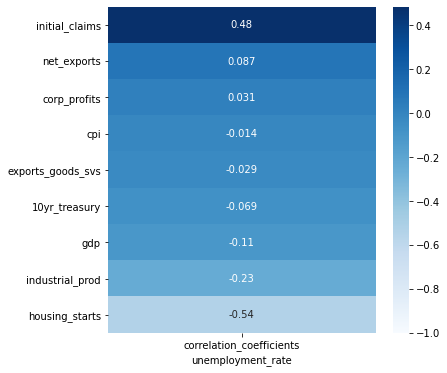



 Correlation coefficients and p values for initial_claims and remaining features:


,correlation_coefficients,p_values
unemployment_rate,0.484518,1.607620e-26
cpi,0.084949,7.953341e-02
gdp,0.042565,3.802812e-01
corp_profits,0.024624,6.118621e-01
exports_goods_svs,0.002062,9.661162e-01
net_exports,-0.021835,6.527590e-01
industrial_prod,-0.033669,4.877542e-01
10yr_treasury,-0.124321,1.012827e-02
housing_starts,-0.140103,3.720601e-03




 Heatmap correlation betwen features and initial_claims:


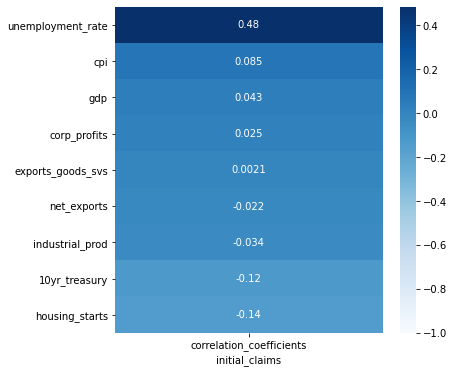



 Correlation coefficients and p values for housing_starts and remaining features:


,correlation_coefficients,p_values
10yr_treasury,0.399477,8.630850e-18
net_exports,0.113403,1.907508e-02
initial_claims,-0.140103,3.720601e-03
industrial_prod,-0.193091,5.914863e-05
gdp,-0.339064,6.009633e-13
cpi,-0.432088,7.514332e-21
corp_profits,-0.437317,2.256678e-21
exports_goods_svs,-0.494099,1.148496e-27
unemployment_rate,-0.535792,4.246492e-33




 Heatmap correlation betwen features and housing_starts:


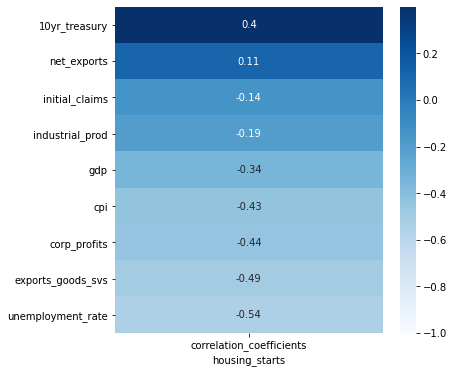

In [ ]:
# Let's examine the correlations of the features to each other in
# search of multicolinearity 

feature_cols = list(df.columns[:-3])
target_cols = list(df.columns[-3:-1])


for column in feature_cols:
    corr_coefs = []
    p_vals = []
    features = feature_cols.copy()
    features.remove(column)

    for feature in features:
        corrcoef = pearsonr(df[column], df[feature])[0]
        pval = pearsonr(df[column], df[feature])[1]
        corr_coefs.append(corrcoef)
        p_vals.append(pval)

    print(f'\n\n Correlation coefficients and p values for {column} and remaining features:')       
    corrs = pd.DataFrame({'correlation_coefficients': corr_coefs, 
                                    'p_values': p_vals}, index=features)
    corrs.sort_values(by='correlation_coefficients', ascending=False, inplace=True)
    display(corrs)

    print(f'\n\n Heatmap correlation betwen features and {column}:')       
    plt.figure(figsize=(6,6))
    sns.heatmap(corrs[['correlation_coefficients']],
            vmin=-1,
            cmap='Blues',
            annot=True)
    plt.xlabel(column)
    plt.show();

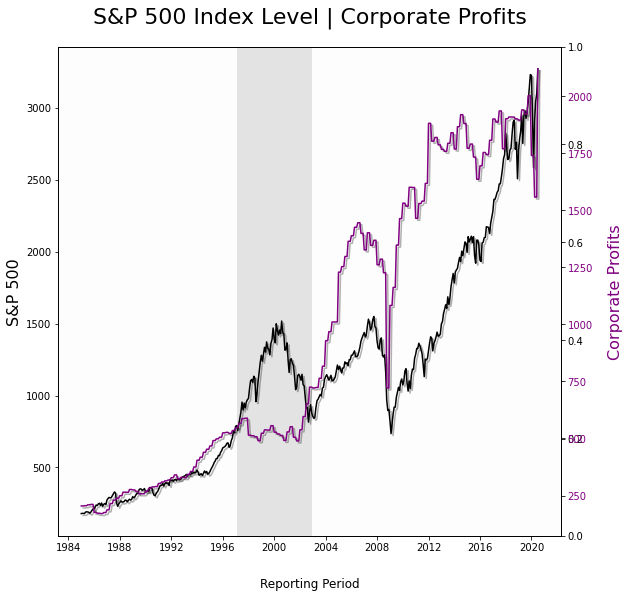

In [ ]:
# SP500 versus Corporate Profits.
# Non-monotonic data

fig, ax = plt.subplots(figsize=(9, 9))

ax.set_facecolor('xkcd:pale grey')
ax.set_title('S&P 500 Index Level | Corporate Profits',
             fontsize=22, pad=24)

ax.set_xlabel('Reporting Period', fontsize=12, labelpad=25)

ax.plot(df.index, df['sp500_close'], color='black', path_effects=
                    [path_effects.SimpleLineShadow(), path_effects.Normal()])
ax.set_ylabel('S&P 500', verticalalignment='bottom', fontsize=16) 
ax.tick_params(axis='y')

ax2 = ax.twinx()
ax2 = ax.twinx()

ax2.plot(df.index, df['corp_profits'], color='purple',
          path_effects=[path_effects.SimpleLineShadow(), path_effects.Normal()])
ax2.set_ylabel('Corporate Profits', color='purple', verticalalignment='top', 
               fontsize=16, labelpad=15)
ax2.tick_params(axis='y', labelcolor='purple')

ax.axvline(x=df.index[180], linewidth=75, color=(0,0,0,0.1))

plt.show()


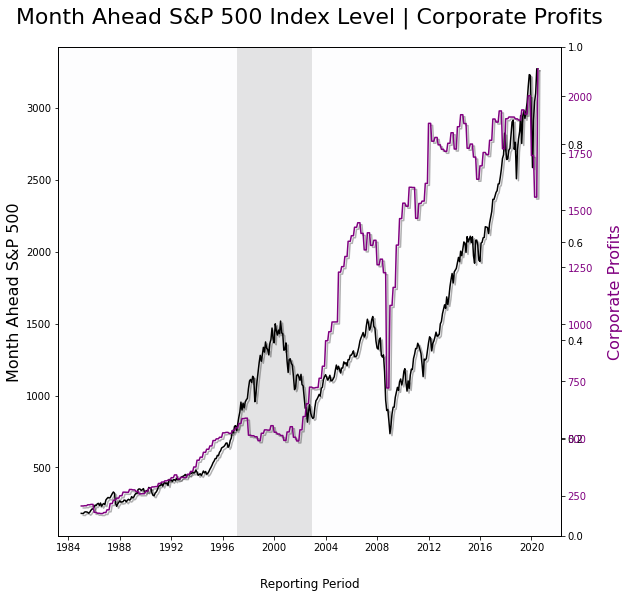

In [ ]:
# SP500-month-ahead versus Corporate Profits.

fig, ax = plt.subplots(figsize=(9, 9))

ax.set_facecolor('xkcd:pale grey')
ax.set_title('Month Ahead S&P 500 Index Level | Corporate Profits',
             fontsize=22, pad=24)

ax.set_xlabel('Reporting Period', fontsize=12, labelpad=25)

ax.plot(df.index, df['sp_ahead'], color='black', path_effects=
                    [path_effects.SimpleLineShadow(), path_effects.Normal()])
ax.set_ylabel('Month Ahead S&P 500', verticalalignment='bottom', fontsize=16) 
ax.tick_params(axis='y')

ax2 = ax.twinx()
ax2 = ax.twinx()

ax2.plot(df.index, df['corp_profits'], color='purple',
          path_effects=[path_effects.SimpleLineShadow(), path_effects.Normal()])
ax2.set_ylabel('Corporate Profits', color='purple', verticalalignment='top', 
               fontsize=16, labelpad=15)
ax2.tick_params(axis='y', labelcolor='purple')

ax.axvline(x=df.index[180], linewidth=75, color=(0,0,0,0.1))

plt.show()

Distribution of corp_profits:


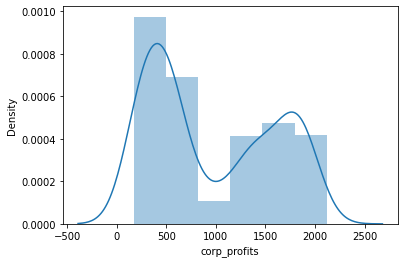



 corp_profits with no transformation versus SP500 ahead




 Natural log distribution of corp_profits


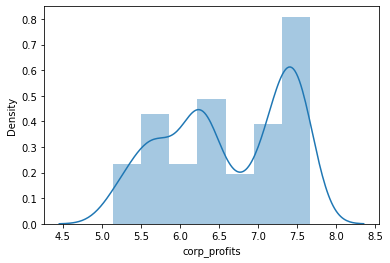



 corp_profits with natural log transformation versus SP500 ahead


Distribution of exports_goods_svs:


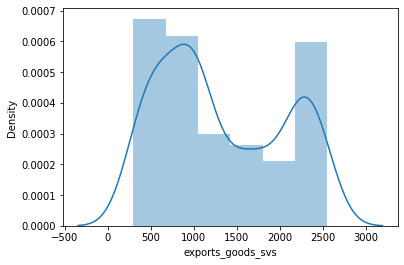



 exports_goods_svs with no transformation versus SP500 ahead




 Natural log distribution of exports_goods_svs


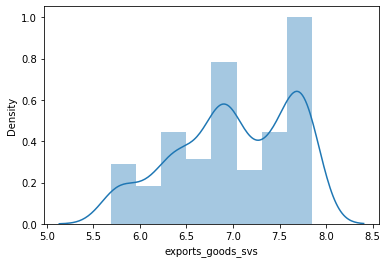



 exports_goods_svs with natural log transformation versus SP500 ahead


Distribution of net_exports:


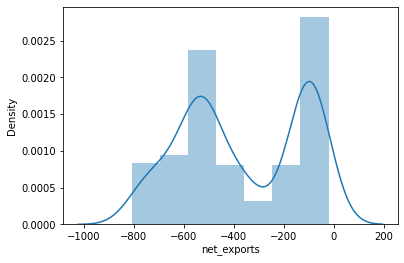



 net_exports with no transformation versus SP500 ahead




 Natural log distribution of net_exports


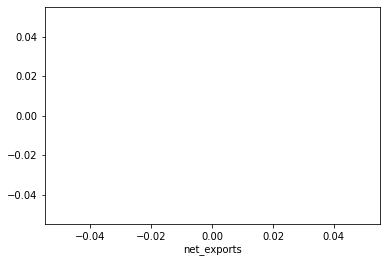



 net_exports with natural log transformation versus SP500 ahead


Distribution of gdp:


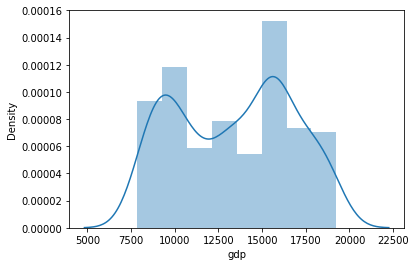



 gdp with no transformation versus SP500 ahead




 Natural log distribution of gdp


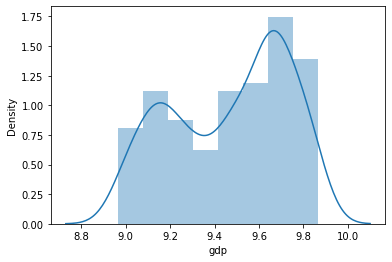



 gdp with natural log transformation versus SP500 ahead


Distribution of 10yr_treasury:


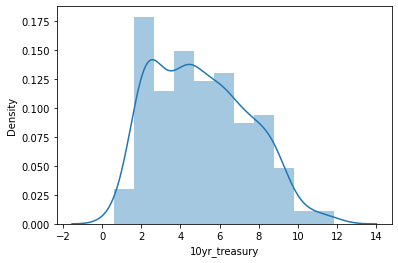



 10yr_treasury with no transformation versus SP500 ahead




 Natural log distribution of 10yr_treasury


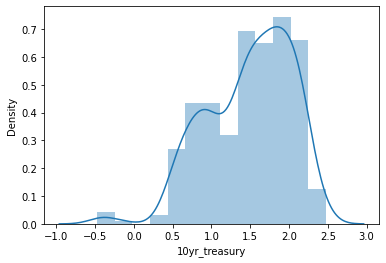



 10yr_treasury with natural log transformation versus SP500 ahead


Distribution of cpi:


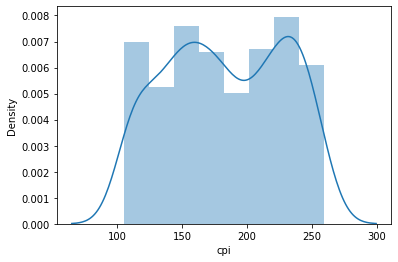



 cpi with no transformation versus SP500 ahead




 Natural log distribution of cpi


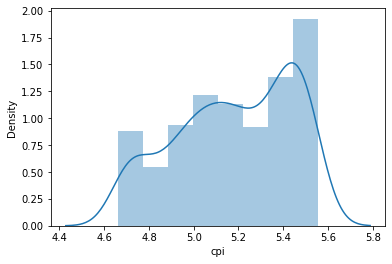



 cpi with natural log transformation versus SP500 ahead


Distribution of industrial_prod:


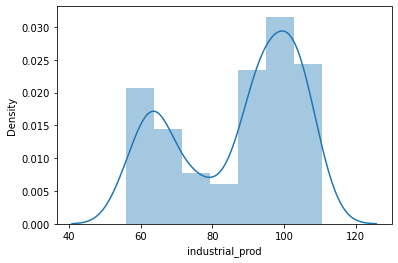



 industrial_prod with no transformation versus SP500 ahead




 Natural log distribution of industrial_prod


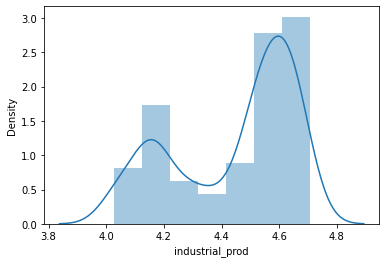



 industrial_prod with natural log transformation versus SP500 ahead


Distribution of unemployment_rate:


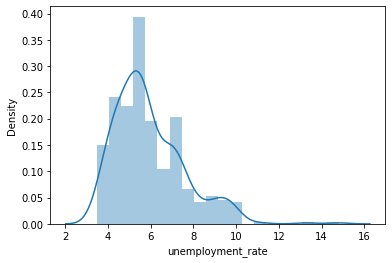



 unemployment_rate with no transformation versus SP500 ahead




 Natural log distribution of unemployment_rate


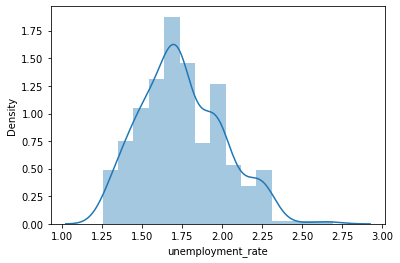



 unemployment_rate with natural log transformation versus SP500 ahead


Distribution of initial_claims:


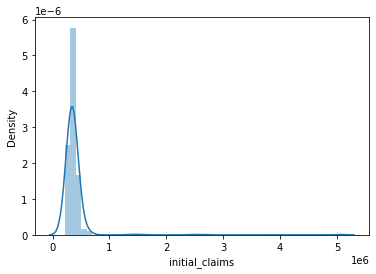



 initial_claims with no transformation versus SP500 ahead




 Natural log distribution of initial_claims


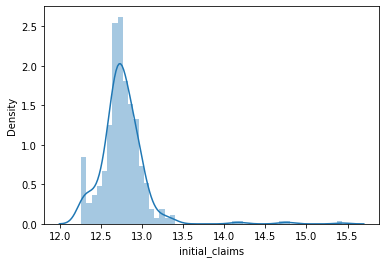



 initial_claims with natural log transformation versus SP500 ahead


Distribution of housing_starts:


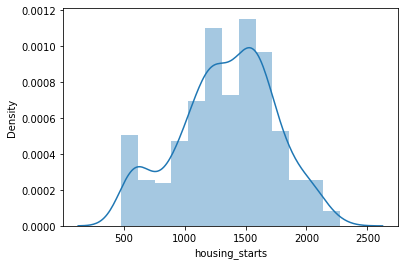



 housing_starts with no transformation versus SP500 ahead




 Natural log distribution of housing_starts


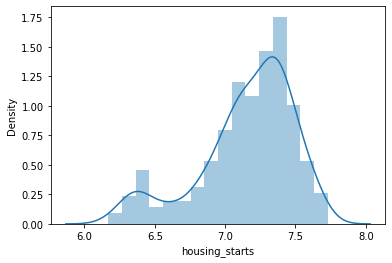



 housing_starts with natural log transformation versus SP500 ahead


In [ ]:
columns = list(df.columns[:-3])

for col in columns:
    print(f'Distribution of {col}:')
    sns.distplot(df[col])
    plt.show();

    print(f'\n\n {col} with no transformation versus SP500 ahead')
    display(px.scatter(df, x=col, y='sp_ahead', trendline='ols'))
    
    print(f'\n\n Natural log distribution of {col}')
    sns.distplot(np.log(df[col]))
    plt.show();
    
    print(f'\n\n {col} with natural log transformation versus SP500 ahead')
    display(px.scatter(df, x=np.log(abs(df[col])), y='sp_ahead', trendline='ols'))
    

In [ ]:
# Create a Feature Matrix and Target Vector
target = 'sp_ahead_pos_neg'

y = df[target]
X = df.drop(columns=target)
# X = df.drop(columns=['sp500_close', 'sp_ahead', 'sp_ahead_pos_neg'])

print(X.shape, y.shape)

(427, 2) (427,)


In [ ]:
# Split the data = create train and test sets 
# Will use 5-fold cross-validation with our training set

mask = df.index < '2014-01-01'

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(348, 2) (348,)
(79, 2) (79,)


In [ ]:
# Let's look at the distribution of the target variable, 'sp_ahead_pos_neg', and determine our 
# majority class - the market has been up in the month ahead about 62.93% of the time.
# There is no gross overweighting of our classes, and we can use accuracy score to assess.
# We will also explore precision/recall and ROC-AUC curves for multiple models. 

baseline_outcomes = y_train.value_counts(normalize=True)*100
print(f'The majority class is True - "The Market Went Up"')
print(f'Our basline accuracy score is {baseline_outcomes[1]:.2f}%')

The majority class is True - "The Market Went Up"
Our basline accuracy score is 62.93%


In [ ]:
# Logistic Regression 
model_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

model_lr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
model_lr.score(X_train, y_train)

0.6293103448275862

In [ ]:
model_lr.score(X_test, y_test)

0.6835443037974683

In [ ]:
# Random Forest Classifier 
model_rf = make_pipeline(
    RandomForestClassifier(random_state=22)
)

model_rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=22,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [ ]:
model_rf.score(X_train, y_train)

0.9022988505747126

In [ ]:
model_rf.score(X_test, y_test)

0.3670886075949367

In [ ]:
# Let's look at some interesting hyperparameters and tune the Logistic Regression model

estimator = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(random_state=22),
)

params = {'logisticregression__C': range(1, 21, 1),
          'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'logisticregression__max_iter': range(130, 141, 1)}

model_rs_lr = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=params,
    n_iter=100,
    n_jobs=-1,
    cv=5,
    verbose=1
)

model_rs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.6s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,
                                                            missing_values=nan,
                                                            strategy='mean',
                                                            verbose=0)),
                                             ('standardscaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('logisticregression',
                          

In [ ]:
model_rs_lr.best_params_

{'logisticregression__C': 5,
 'logisticregression__max_iter': 134,
 'logisticregression__solver': 'lbfgs'}

In [ ]:
model_rs_lr.best_score_

0.6293167701863354

In [ ]:
model_rs_lr.score(X_test, y_test)

0.6835443037974683

In [ ]:
model_rc = make_pipeline(
    StandardScaler(),
    RidgeClassifierCV(alphas=[ 0.1,  1. , 10., 25.0, 55.0, 100.0 ], cv=10)
)

model_rc.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ridgeclassifiercv',
                 RidgeClassifierCV(alphas=array([  0.1,   1. ,  10. ,  25. ,  55. , 100. ]),
                                   class_weight=None, cv=10, fit_intercept=True,
                                   normalize=False, scoring=None,
                                   store_cv_values=False))],
         verbose=False)

In [ ]:
model_rc.score(X_train, y_train)

0.6293103448275862

In [ ]:
model_rc.score(X_test, y_test)

0.6835443037974683

In [ ]:
coefficients = model_rc.named_steps['ridgeclassifiercv'].coef_
feature_names = X_train.columns

feature_importances = pd.Series(coefficients[0], index=feature_names)
feature_importances

exports_goods_svs   -0.028788
unemployment_rate    0.040492
dtype: float64

Text(0.5, 1.0, 'Feature Coefficients for Ridge Classifier CV model')

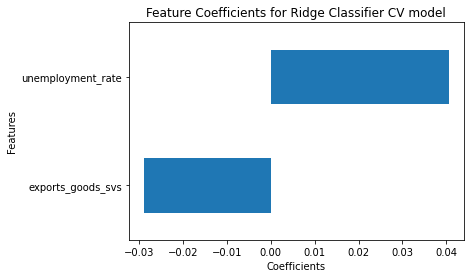

In [ ]:
feature_importances.sort_values().plot(kind='barh')
plt.xlabel('Coefficients')
plt.ylabel('Features')
plt.title('Feature Coefficients for Ridge Classifier CV model')


In [ ]:
perm_imps = permutation_importance(
    model_rc, 
    X_test, 
    y_test,
    n_jobs=-1,
    random_state=22)
perm_imps

data = {'importances_mean': perm_imps['importances_mean'],
        'importrances_std': perm_imps['importances_std']}

df = pd.DataFrame(data, index=X_test.columns)
df.sort_values(by='importances_mean', ascending=False, inplace=True)
df

,importances_mean,importrances_std
exports_goods_svs,0.0,0.0
unemployment_rate,0.0,0.0


In [ ]:
# Let's look at some interesting hyperparameters and tune the Ridge Classifier model

estimator = make_pipeline(
    StandardScaler(),
    RidgeClassifier(random_state=22),
)

params = {'ridgeclassifier__alpha': range(1, 221, 10)}

model_gs_rc = GridSearchCV(
    estimator=estimator,
    param_grid=params,
    n_jobs=-1,
    cv=5,
    verbose=1
)

model_gs_rc.fit(X_train, y_train)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    0.8s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('ridgeclassifier',
                                        RidgeClassifier(alpha=1.0,
                                                        class_weight=None,
                                                        copy_X=True,
                                                        fit_intercept=True,
                                                        max_iter=None,
                                                        normalize=False,
                                                        random_state=22,
                                                        solver='auto',
                  

In [ ]:
model_gs_rc.best_params_

{'ridgeclassifier__alpha': 1}

In [ ]:
model_gs_rc.best_score_

0.6293167701863354

In [ ]:
model_gs_rc.score(X_test, y_test)

0.6835443037974683

In [ ]:
model_gs_rc.estimator.named_steps['ridgeclassifier'].coef_

AttributeError: ignored

In [ ]:
# country_grp = df.groupby(['Country'])
# country_grp['LanguageWorkedWith'].str.contains('Python').sum()
# country_uses_python = country_grp['LanguageWorkedWIth'].apply(lambda x: x.str.contains('Python').sum())
# country_uses_python = country_grp['LanguafeWorkedWith'].apply(lambda x: x.str.contains('Python').sum())

# pyton_df = pd.concat(['country_respondents', 'country_uses_python'], axis='columns', sort=False)

In [ ]:
# model_XGBC = make_pipeline(
#     SimpleImputer(strategy='mean'),
#     XGBClassifier(max_depth=5, learning_rate=0.01, 
#                   n_estimators=2000, colsample_bytree=0.1,
#                   n_jobs=-1, random_state=22)
# )

# model_XGBC.fit(X_train, y_train)


# imputer_object = SimpleImputer(strategy='mean')
# X_train_imputed = imputer_object.fit_transform(X_train)
# X_test_imputed = imputer_object.transform(X_test)

# model_XGBC = XGBClassifier(max_depth=8, learning_rate=0.01, 
#                   n_estimators=50, colsample_bytree=0.1,
#                   n_jobs=-1, random_state=22)


# model_XGBC.fit(X_train, y_train)


model_XGBC = XGBClassifier(random_state=22)


model_XGBC.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=22,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# params = {'xgbclassifier__max-depth': range(5, 25, 3),
#           'xgbclassifier__learning_rate': np.arange(0.01, 0.9, 0.01),
#           'xgbclassifier__n_estimators': range(100, 2000, 10),
#           'xgbclassifier__colsample_bytree': np.arange(0.01, 0.9, 0.01)}

params = {'max-depth': range(5, 25, 3),
          'learning_rate': np.arange(0.01, 0.9, 0.01),
          'n_estimators': range(100, 2000, 10),
          'colsample_bytree': np.arange(0.01, 0.9, 0.01)}

model_rs_XGBC = RandomizedSearchCV(
    estimator=model_XGBC,
    param_distributions=params,
    n_iter=100,
    n_jobs=-1,
    cv=5,
    verbose=1
)

model_rs_XGBC.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 454 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=22, reg_alpha=0,
                                           reg_lambda=1, s...
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 

In [ ]:
model_rs_XGBC.best_params_

{'colsample_bytree': 0.3,
 'learning_rate': 0.01,
 'max-depth': 11,
 'n_estimators': 320}

In [ ]:
model_rs_XGBC.score(X_test, y_test)

0.4936708860759494

In [ ]:
model_rs_XGBC.best_score_

0.5944927536231883

In [ ]:
model_XGBC.score(X_train, y_train)

0.8505747126436781

In [ ]:
model_XGBC.score(X_test, y_test)

0.569620253164557

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f437785e510>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f43736f0e90>})

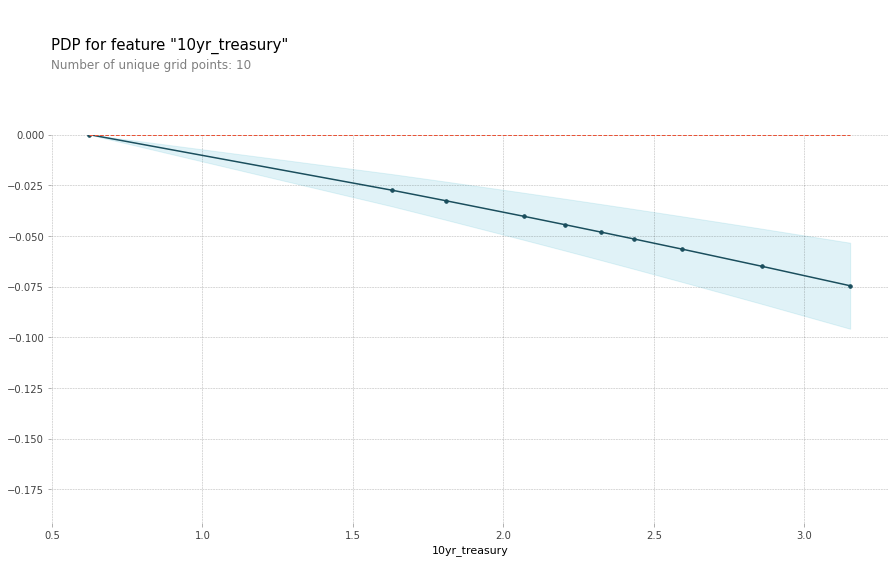

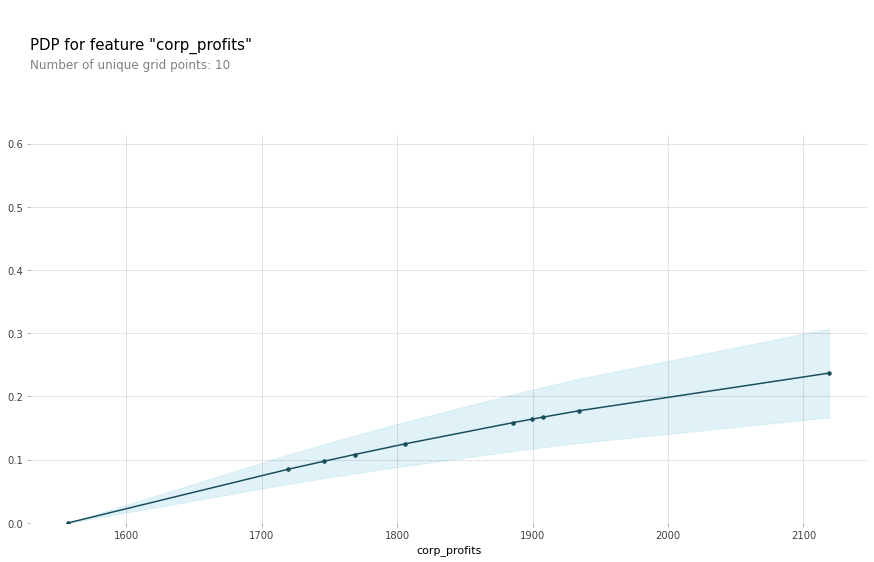

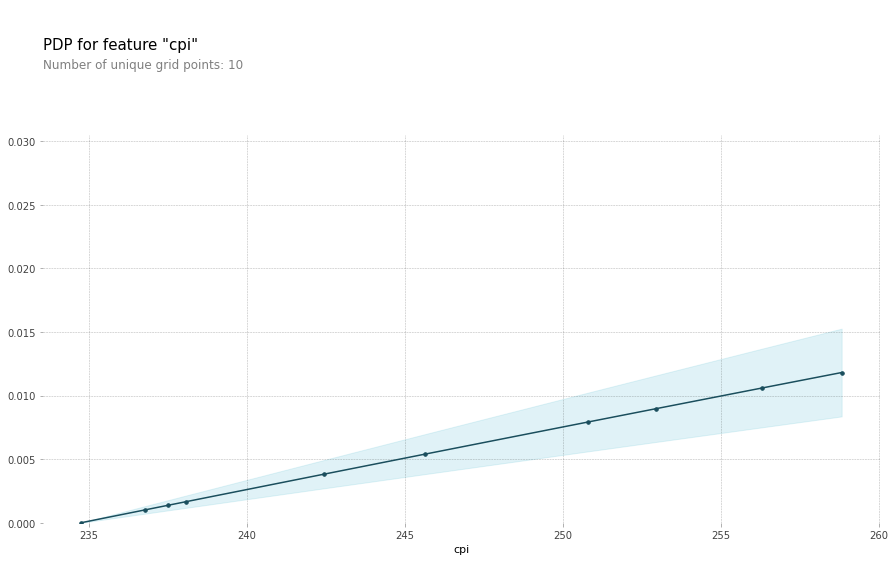

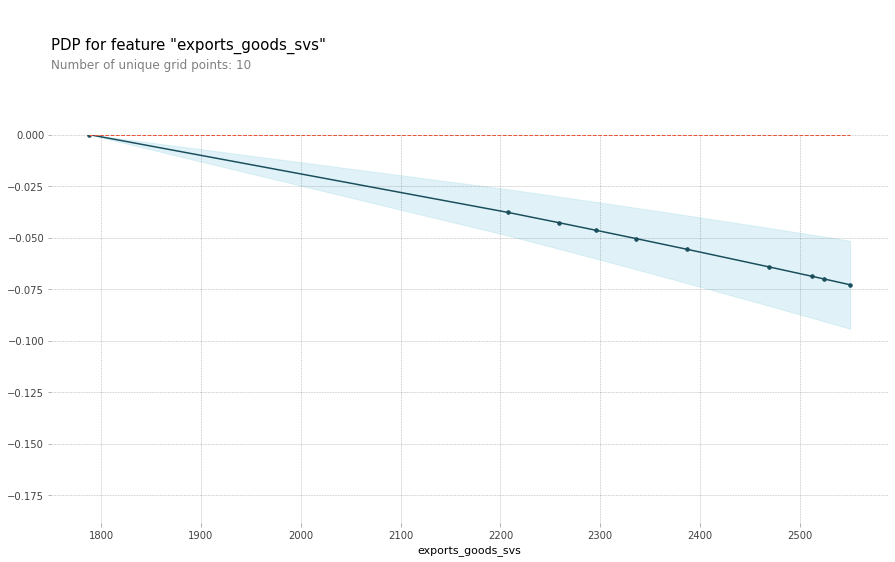

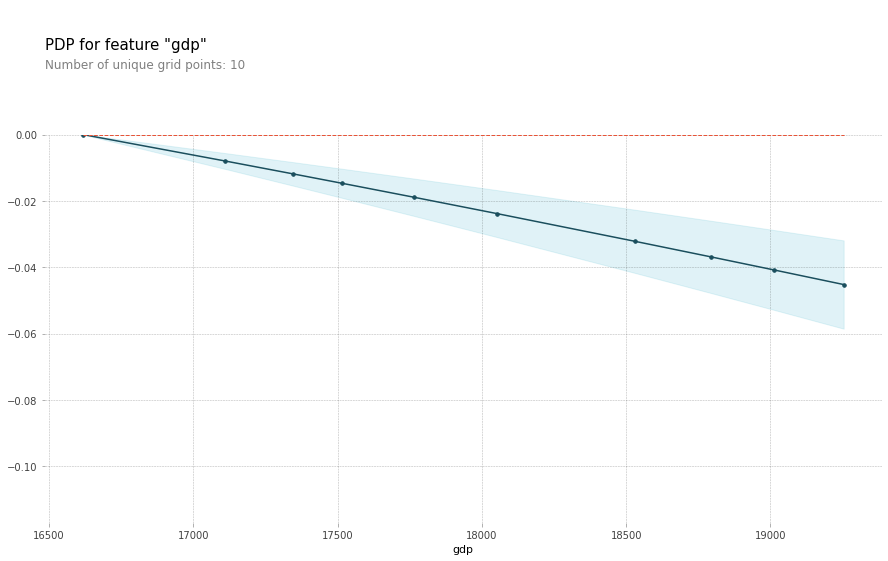

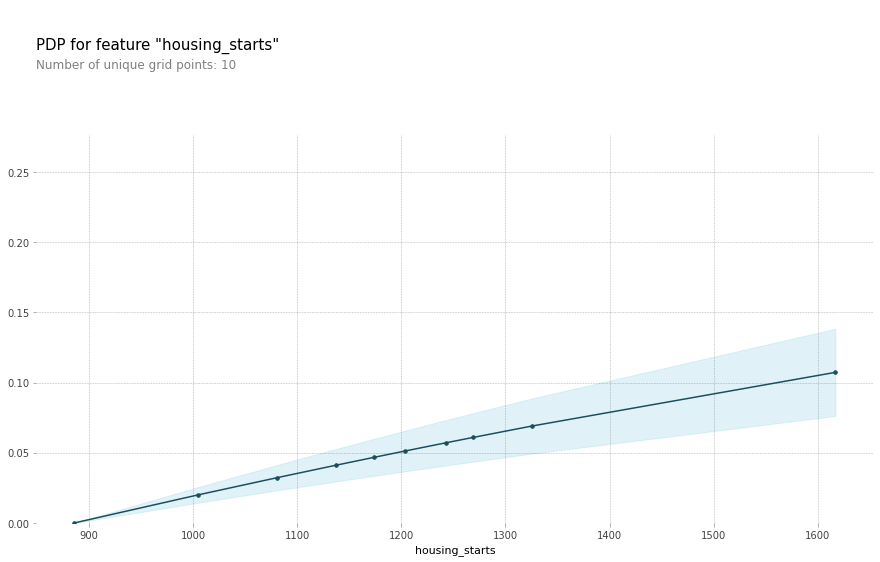

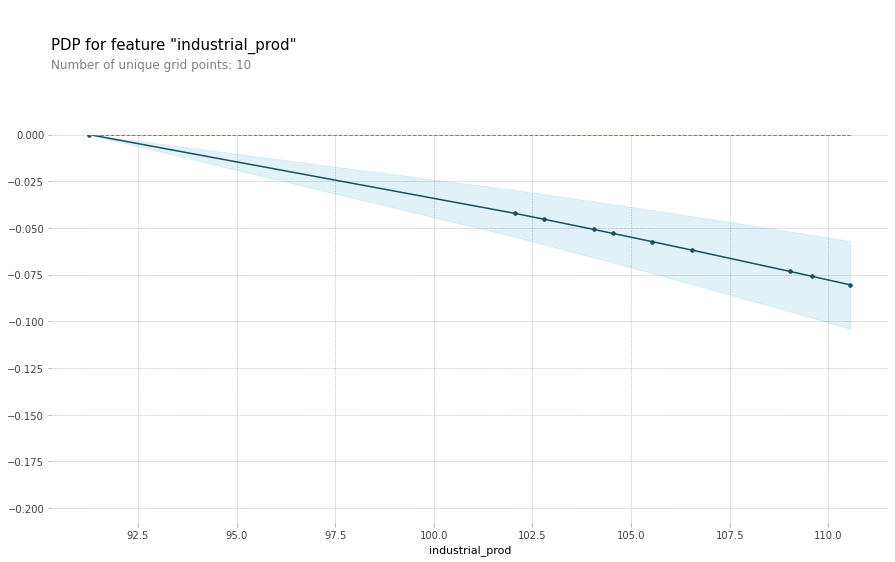

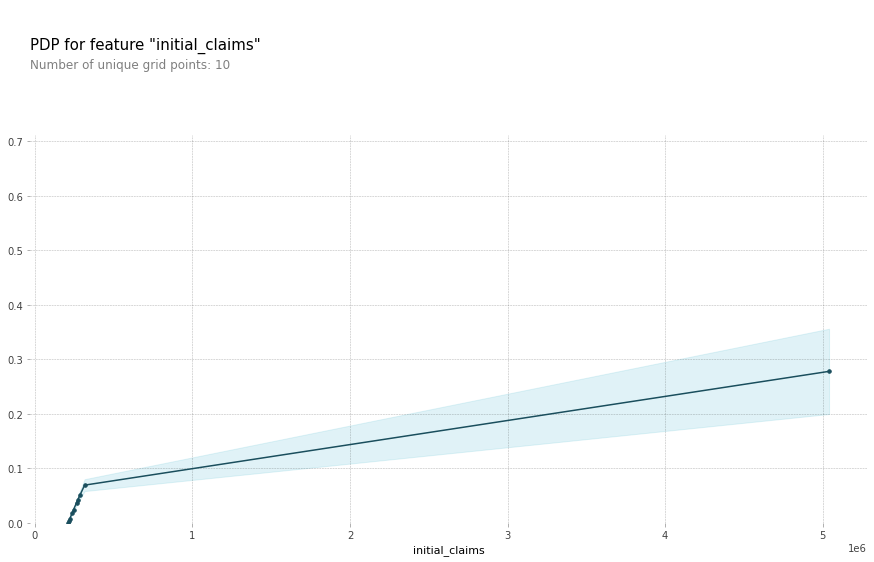

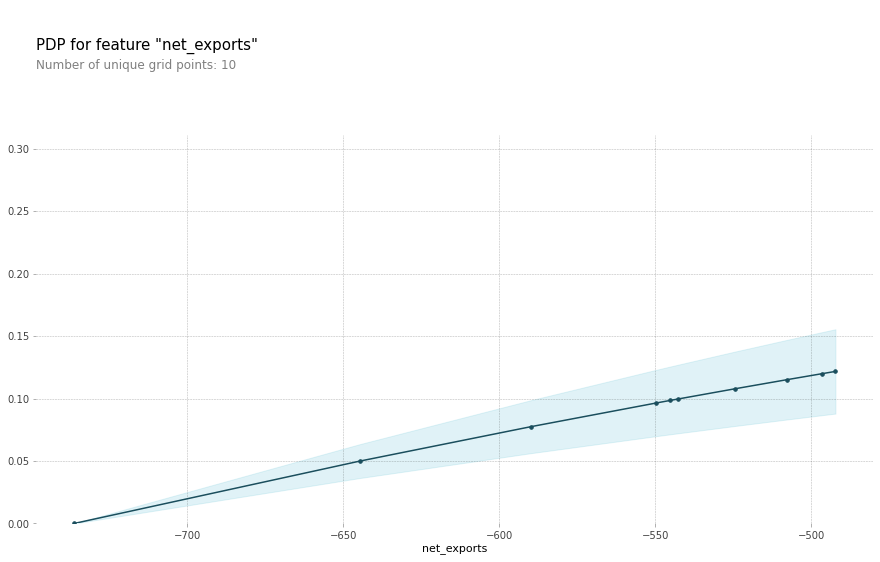

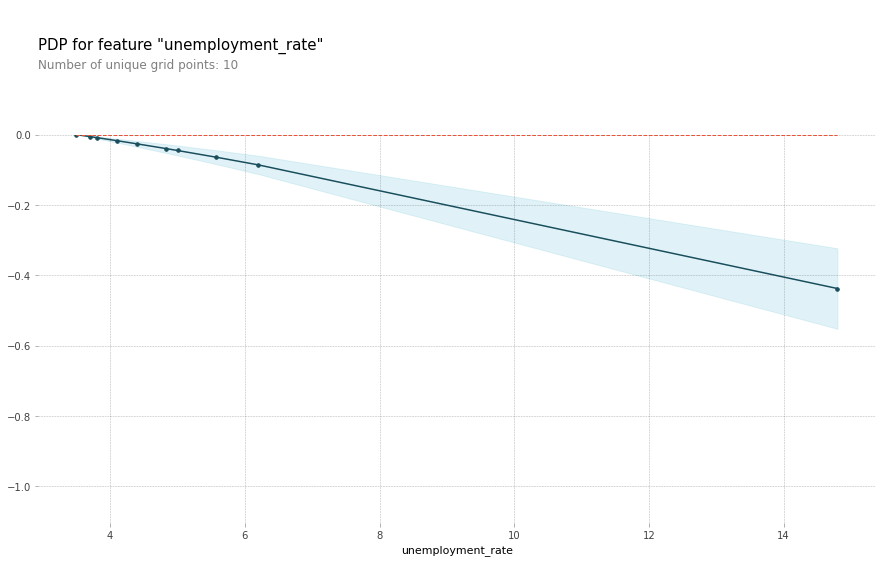

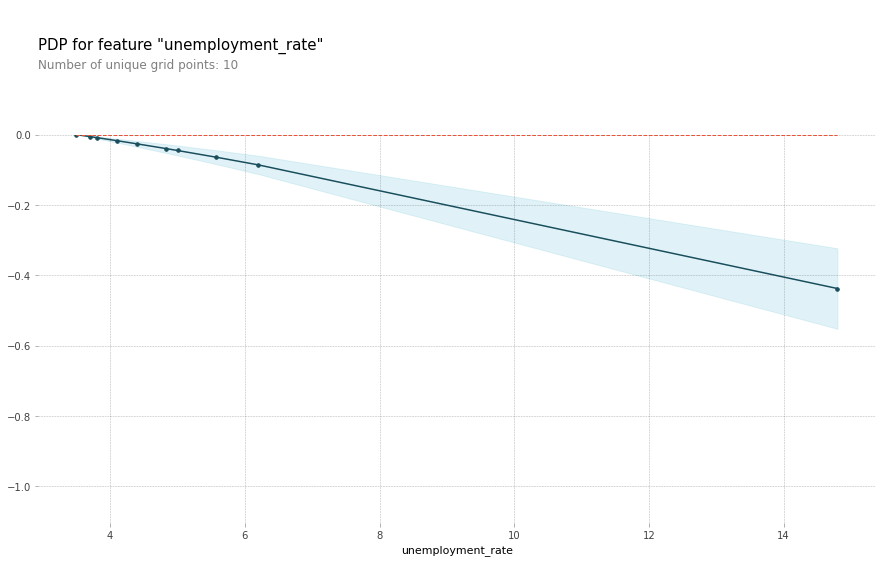

In [ ]:
# PDP isolate for corporate profits

# feature = 'corp_profits'
features = list(X_test.columns)

for feature in features:
    isolate = pdp_isolate(
        model=model_lr,
        dataset=X_test,
        model_features=X_test.columns,
        feature=feature
    )
    pdp_plot(isolate, feature_name=feature);


pdp_plot(isolate, feature)


(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4378aec6d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4378577fd0>})

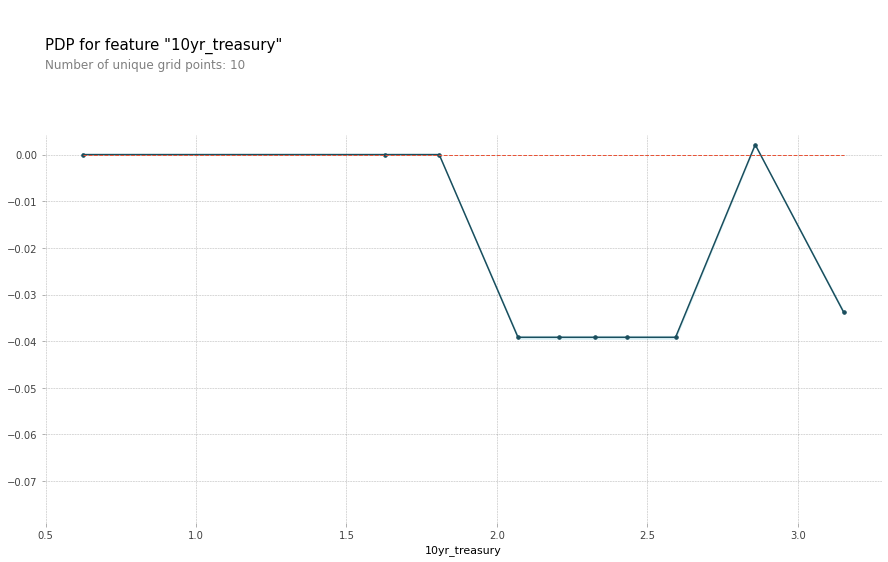

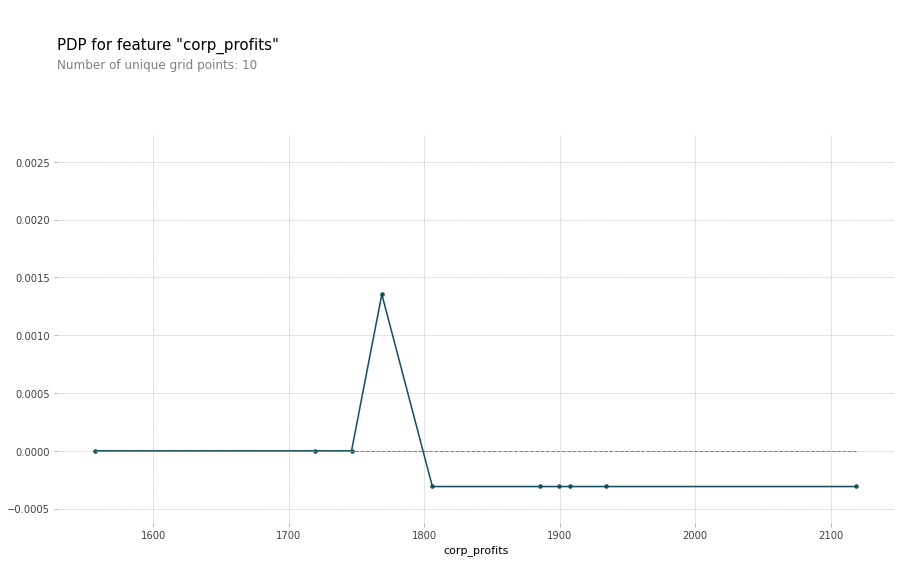

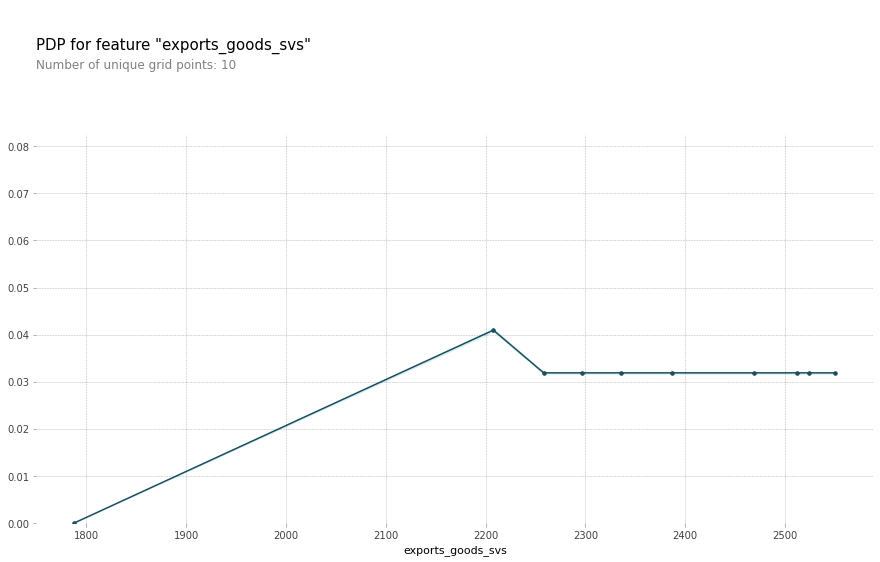

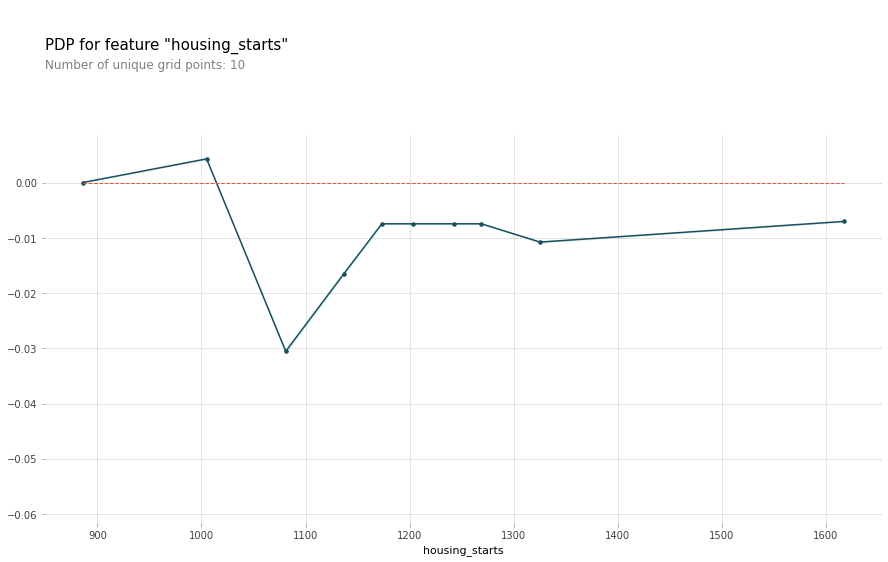

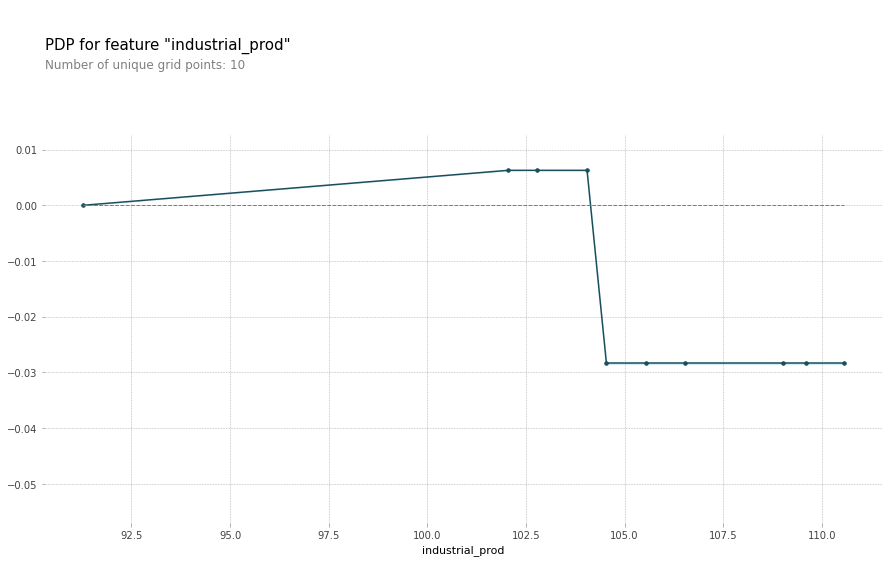

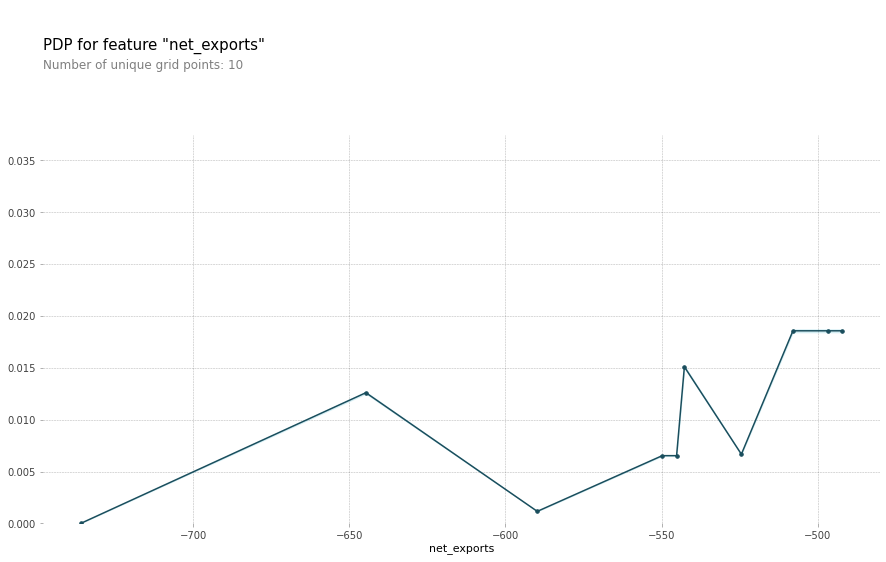

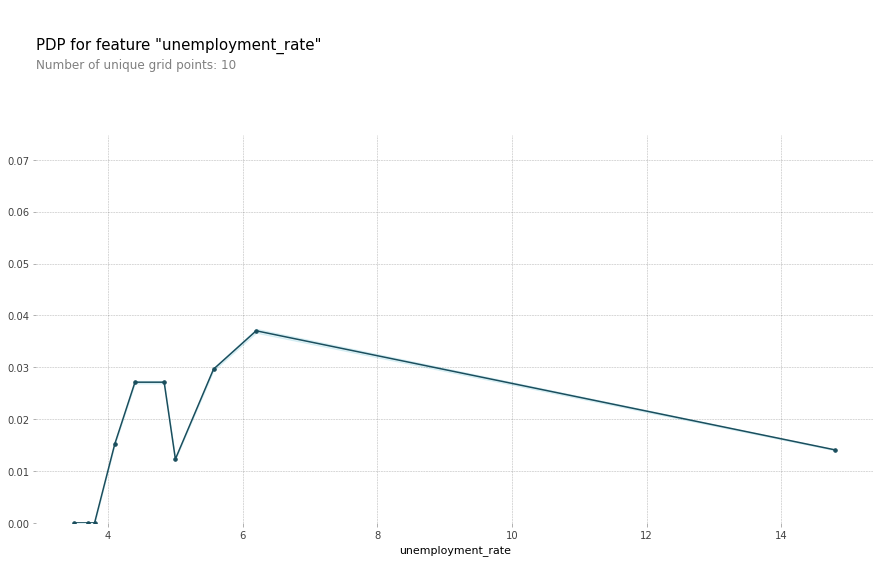

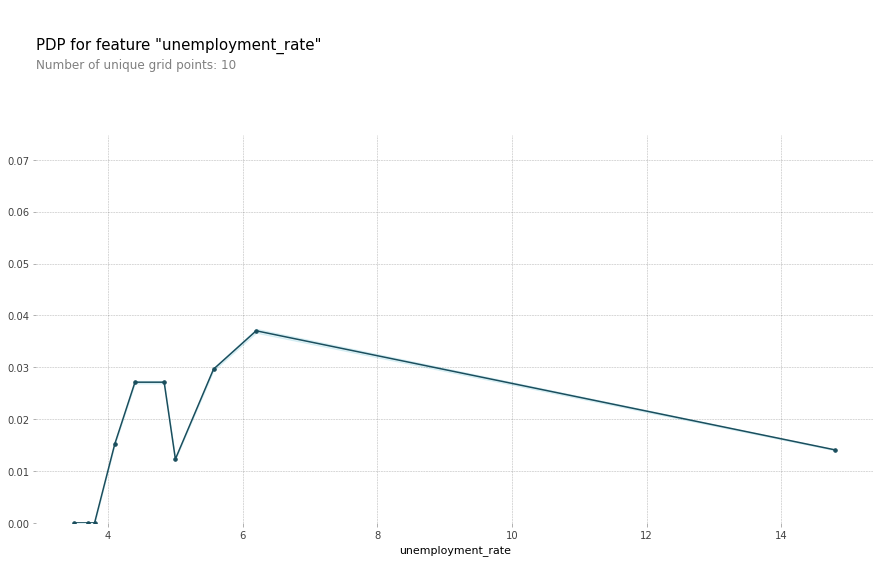

In [ ]:
# PDP isolate for corporate profits

feature = 'corp_profits'
features = list(X_test.columns)

for feature in features:
    isolate = pdp_isolate(
        model=model_XGBC,
        dataset=X_test,
        model_features=X_test.columns,
        feature=feature
    )
    pdp_plot(isolate, feature_name=feature);


pdp_plot(isolate, feature)


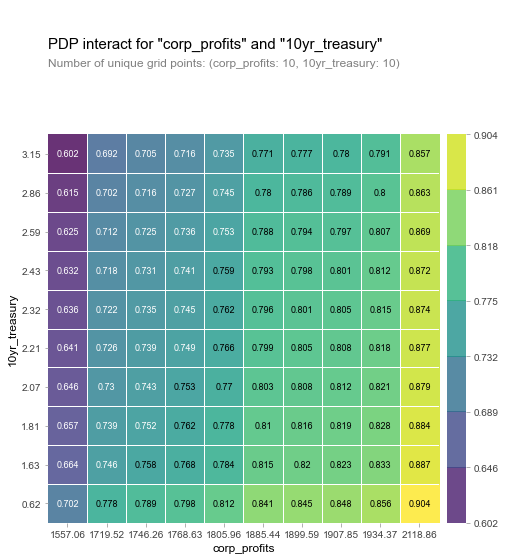

In [ ]:
features = ['corp_profits', '10yr_treasury']

interact = pdp_interact(
    model=model_lr,
    dataset=X_test,
    model_features=X_test.columns,
    features=features
)

pdp_interact_plot(interact, plot_type='grid', feature_names=features);

In [ ]:
row = X_test.iloc[[0]]

In [ ]:
model_lr.predict(row)

array([ True])

In [ ]:
import shap

explainer = shap.TreeExplainer(model_XGBC)
shap_values = explainer.shap_values(row)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

ValueError: ignored